# COMP5318 - Machine Learning and Data Mining: Assignment 1
<div style="text-align: right"> Due: Wednesday 14 Oct 2020 11:59PM </div>

The goal of this assignment is to build a classifier to classify some grayscale images of the size 28x28 into a set of categories. The dimension of the original data is large, so you need to be smart on which method you gonna use and perhaps perform a pre-processing step to reduce the amount of computation. Part of your marks will be a function of the performance of your classifier on the test set.

# Load Libraries

In [1]:
import h5py
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

print(os.listdir("./Input/train"))

['images_training.h5', 'labels_training.h5']


# Load Data

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)

(30000, 784) (30000,)


In [3]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_test.shape,label_test.shape)

(5000, 784) (2000,)


# Principal Component Analysis


<div style="text-align: right"> Sourced: https://stats.stackexchange.com/questions/125172/pca-on-train-and-test-datasets-should-i-run-one-pca-on-traintest-or-two-separa </div>
<div style="text-align: right"> https://towardsdatascience.com/pca-with-numpy-58917c1d0391 </div>
<div style="text-align: right"> https://stackoverflow.com/questions/10818718/principal-component-analysis </div>



## Computing the Eigenvectors and Eigenvalues

The classifier is being trained on data in the space defined by the principle components of the training data. Therefore, must apply the same transformation to testing data.

In [12]:
data = np.concatenate([data_train, data_test], axis=0) #join the two training and test datasets
print(data.shape)
covariance_matrix = np.cov(data.T)
#print(covariance_matrix)
eig_val, eig_vec = np.linalg.eig(covariance_matrix)
print("First 20 Eigenvalues: \n", eig_val[:20], "\n")

(35000, 784)
First 20 Eigenvalues: 
 [19.87519635 12.07981371  4.08596855  3.3642606   2.61933518  2.35302943
  1.61334551  1.27832308  0.91569278  0.89224929  0.6740978   0.62151455
  0.52368721  0.44764279  0.41482966  0.40166959  0.37871065  0.36395851
  0.31619539  0.30998151] 



## Picking Principal Components


In [18]:
variance_explained = []
for i in eig_val:
    variance_explained.append((i/sum(eig_val))*100)     
print("First 40 Variance Explained: \n", variance_explained[:40], "\n") 

cumulative_variance_explained = np.cumsum(variance_explained)
print("First 40 Cummulative Variance Explained: \n", cumulative_variance_explained[:40], "\n") 


First 40 Variance Explained: 
 [29.12763185419586, 17.703290089309917, 5.988096191731622, 4.930413895189553, 3.8387057626109256, 3.4484275645562232, 2.364401001605165, 1.873416666108097, 1.3419722579545015, 1.3076152066717355, 0.9879083552882953, 0.9108461919258826, 0.7674776078747019, 0.6560324883747961, 0.6079439645798298, 0.5886575228106977, 0.5550105861419041, 0.5333909279765046, 0.4633928047277631, 0.45428619006266135, 0.43212446228177503, 0.40573378103361285, 0.3854422616430919, 0.37239334791915074, 0.3628409679087214, 0.35328369249420977, 0.3341810252095097, 0.31971063165980584, 0.30903892867902105, 0.29241640781074196, 0.278190841041694, 0.2681197966980804, 0.26324595521106187, 0.2564250783295049, 0.24910022102531437, 0.2368931855076619, 0.23052390396415717, 0.22490365688810748, 0.22060527230842608, 0.21020349396095395] 

First 40 Cummulative Variance Explained: 
 [29.12763185 46.83092194 52.81901814 57.74943203 61.58813779 65.03656536
 67.40096636 69.27438303 70.61635528 71.92

### Plot Cumulative explained variance to find elbow point

Text(0.5, 1.0, 'Explained variance vs Number of components')

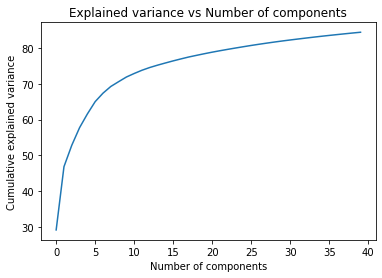

In [19]:

sns.lineplot(x = np.arange(40), y=cumulative_variance_explained[:40])
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Explained variance vs Number of components")

## Project Data Onto Lower-Dimensional Linear Subspace

In [20]:
projection_matrix = (eig_vec.T[:][:40]).T
X_pca = data.dot(projection_matrix)

X_train_pca = X_pca[:data_train.shape[0]]
X_test_pca = X_pca[-data_test.shape[0]:]
print(X_train_pca.shape)
print(X_test_pca.shape)

(30000, 40)
(5000, 40)


# Cross Validation
10-Fold cross validation between 8-15 k-nearest neigbhours.

In [5]:
%%time

k = 10 # number of folds for cv
indices_cv = KFold(n_splits=10, random_state=None, shuffle=False) # indices for the k-folds
pca_scores = []
n_comp_list = np.arange(8, 15)
for K in n_comp_list:
    knn = KNeighborsClassifier(n_neighbors=K)
    score = 0
    count = 1
    for train_index, test_index in indices_cv.split(X_train_pca):
        print("comp", K, " fold", count)
        count+=1
        test_id = test_index
        train_id = train_index
        y_true = label_train[test_id]
        model = knn.fit(X_train_pca[train_id], label_train[train_id])
        score += model.score(X_train_pca[test_index], label_train[test_id])
    pca_scores.append(score/k)
pca_scores = np.array(pca_scores)


comp 8  fold 1
comp 8  fold 2
comp 8  fold 3
comp 8  fold 4
comp 8  fold 5
comp 8  fold 6
comp 8  fold 7
comp 8  fold 8
comp 8  fold 9
comp 8  fold 10
comp 9  fold 1
comp 9  fold 2
comp 9  fold 3
comp 9  fold 4
comp 9  fold 5
comp 9  fold 6
comp 9  fold 7
comp 9  fold 8
comp 9  fold 9
comp 9  fold 10
comp 10  fold 1
comp 10  fold 2
comp 10  fold 3
comp 10  fold 4
comp 10  fold 5
comp 10  fold 6
comp 10  fold 7
comp 10  fold 8
comp 10  fold 9
comp 10  fold 10
comp 11  fold 1
comp 11  fold 2
comp 11  fold 3
comp 11  fold 4
comp 11  fold 5
comp 11  fold 6
comp 11  fold 7
comp 11  fold 8
comp 11  fold 9
comp 11  fold 10
comp 12  fold 1
comp 12  fold 2
comp 12  fold 3
comp 12  fold 4
comp 12  fold 5
comp 12  fold 6
comp 12  fold 7
comp 12  fold 8
comp 12  fold 9
comp 12  fold 10
comp 13  fold 1
comp 13  fold 2
comp 13  fold 3
comp 13  fold 4
comp 13  fold 5
comp 13  fold 6
comp 13  fold 7
comp 13  fold 8
comp 13  fold 9
comp 13  fold 10
comp 14  fold 1
comp 14  fold 2
comp 14  fold 3
comp 1

## Visualisation of Cross Validaiton

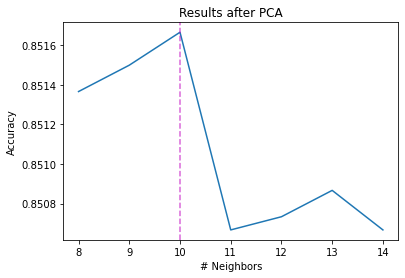

In [6]:
fig, ax = plt.subplots()
n_comp_list = np.arange(8, 15)
ax.plot(n_comp_list, pca_scores)
ax.axvline(n_comp_list[np.argmax(pca_scores)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(n_comp_list)
ax.set_title('Results after PCA')
plt.show()

# Prediciton on Tuned Model

In [22]:
%%time

y_true = label_test
knn = KNeighborsClassifier(n_neighbors=np.argmax(pca_scores), algorithm="kd_tree")
knn.fit(X_train_pca, label_train)
y_pred = knn.predict(X_test_pca)
print(knn.score(X_test_pca[:2000], label_test))

0.82
CPU times: user 3.4 s, sys: 64.9 ms, total: 3.46 s
Wall time: 4.9 s


In [21]:
y_true = np.array(y_true)
print(y_true[:10])
y_pred = np.array(y_pred)
print(y_pred[:10])
np.sum(y_true == y_pred[:2000])/len(y_true)

[1 8 1 8 4 0 4 5 3 1]
[1 8 1 8 4 0 6 9 3 1]


0.82